<a href="https://colab.research.google.com/github/Wnjoki/yuYpOTrvBrzkHSgq-MonReader/blob/main/MonReader_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

import os
from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Load the Images

In [3]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#paths to the training and testing sets
base_dir = '/content/drive/MyDrive/Colab Notebooks/images'
train_dir = os.path.join(base_dir, 'training')
test_dir = os.path.join(base_dir, 'testing')

In [5]:
os.listdir(base_dir)

['training', 'testing']

Create Tensorflow datasets

We use `image_dataset_from_directory` as it will infer the classes from the folder.


When using the function to generate the dataset, you will need to define the following parameters:

-The path to the data
an optional seed for shuffling and transformations
-The `image_size` is the size the images will be resized to after being loaded from the disk
-`batch_size`  images will be loaded in batches
In the absence of a validation set, you can also define a `validation_split`. If it is set, the `subset` also needs to be passed. That is to indicate whether the split is a validation or training split.

In [6]:
training_set = tf.keras.preprocessing.image_dataset_from_directory(
train_dir,
seed=101,
image_size=(224, 224),
batch_size=32)

Found 2392 files belonging to 2 classes.


In [7]:
class_names = training_set.class_names

class_names

['flip', 'notflip']

In [8]:
validation_set = tf.keras.preprocessing.image_dataset_from_directory(
test_dir,
seed=101,
image_size=(224, 224),
batch_size=32)

Found 597 files belonging to 2 classes.


#Data augmentation

Data augmentation is  applied in order to prevent overfitting. Augmenting the images increases the dataset as well as exposes the model to various aspects of the data. Augmentation can be achieved by applying random transformations such as flipping and rotating the images.

In [9]:
data_augmentation = keras.Sequential(
  [
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal",
                                                 input_shape=(224, 224,3)),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
  ]
)


#Model Definition

In [10]:
model = Sequential([
    data_augmentation,
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    Conv2D(filters=32,kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(filters=64,kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),


    Conv2D(filters=128,kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),


    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

Visualize the model

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                  

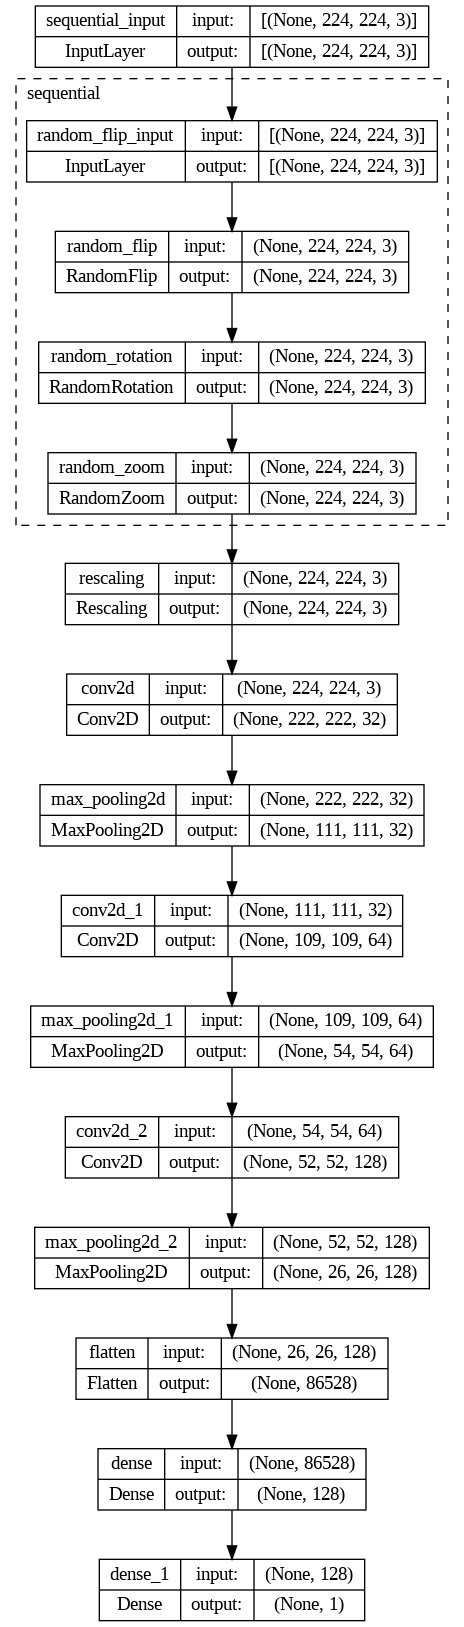

In [12]:
#Plot the model
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
)

#Compiling the model

In [13]:
model.compile(optimizer='adam',
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])

In [14]:
from tensorflow.keras import backend as K


def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    actual_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (actual_positives + K.epsilon())
    return recall


def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_m])

In [15]:
#define callbacks
callbacks = [
             EarlyStopping(patience=2)
]

Early stopping helps to avoid overfitting on training data as it stops the training when the model stops improving.



#Training the Model

In [16]:
history = model.fit(training_set,validation_data=validation_set, epochs=20,callbacks=callbacks)

Epoch 1/20
75/75 [==============================] - 259s 3s/step - loss: 0.7125 - accuracy: 0.5406 - f1_m: 0.5686 - val_loss: 0.6856 - val_accuracy: 0.5561 - val_f1_m: 0.6886
Epoch 2/20
75/75 [==============================] - 31s 384ms/step - loss: 0.6822 - accuracy: 0.5556 - f1_m: 0.4593 - val_loss: 0.6864 - val_accuracy: 0.5410 - val_f1_m: 0.6878
Epoch 3/20
75/75 [==============================] - 31s 386ms/step - loss: 0.6406 - accuracy: 0.6375 - f1_m: 0.6703 - val_loss: 0.6114 - val_accuracy: 0.6533 - val_f1_m: 0.7330
Epoch 4/20
75/75 [==============================] - 31s 387ms/step - loss: 0.6131 - accuracy: 0.6739 - f1_m: 0.6991 - val_loss: 0.6136 - val_accuracy: 0.6449 - val_f1_m: 0.6887
Epoch 5/20
75/75 [==============================] - 35s 411ms/step - loss: 0.6255 - accuracy: 0.6597 - f1_m: 0.6894 - val_loss: 0.6048 - val_accuracy: 0.6951 - val_f1_m: 0.7137
Epoch 6/20
75/75 [==============================] - 33s 392ms/step - loss: 0.6089 - accuracy: 0.6777 - f1_m: 0.7028 -

#Monitoring the model’s performance

In [17]:
#obtain the training losses and accuracies
metrics_df = pd.DataFrame(history.history)
metrics_df

,loss,accuracy,f1_m,val_loss,val_accuracy,val_f1_m
0,0.712512,0.540552,0.568630,0.685629,0.556114,0.688638
1,0.682165,0.555602,0.459306,0.686424,0.541039,0.687801
2,0.640592,0.637542,0.670335,0.611449,0.653266,0.733019
3,0.613126,0.673913,0.699069,0.613550,0.644891,0.688695
4,0.625493,0.659699,0.689372,0.604786,0.695142,0.713677
5,0.608890,0.677676,0.702804,0.588883,0.730318,0.739775
6,0.596156,0.686873,0.720962,0.555803,0.726968,0.725506
7,0.559979,0.722826,0.743483,0.524125,0.720268,0.751639
8,0.539531,0.730769,0.749290,0.518175,0.738693,0.740312
9,0.498327,0.767140,0.775378,0.482252,0.768844,0.790641


Traning and Validation Loss


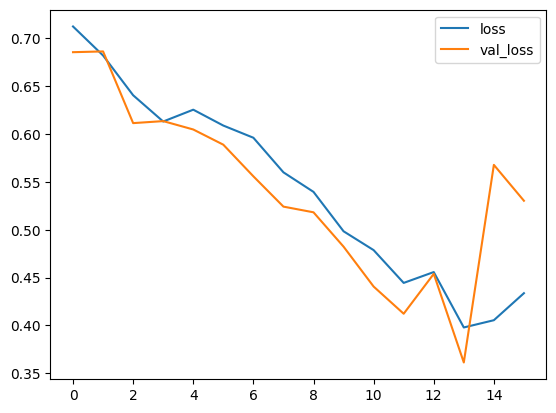

In [18]:
#plot the metrics
print("Traning and Validation Loss")
metrics_df[["loss","val_loss"]].plot();

Traning and Validation Accuracy


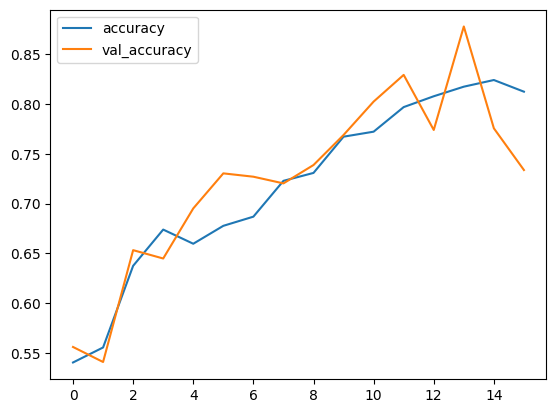

In [19]:
print("Traning and Validation Accuracy")
metrics_df[["accuracy","val_accuracy"]].plot();

Traning and Validation f1 score


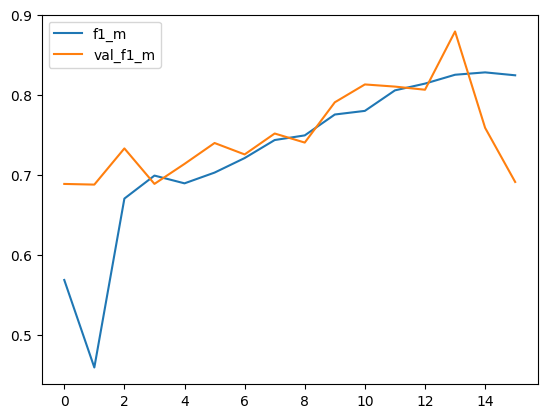

In [20]:
print("Traning and Validation f1 score")
metrics_df[["f1_m","val_f1_m"]].plot();

#Model Evaluation

In [24]:
results = model.evaluate(validation_set)
loss = results[0]
accuracy = results[1]
print(f'Loss on test dataset: {loss:.2f}')
print(f'Accuracy on test dataset: {accuracy * 100:.2f}%')

19/19 [==============================] - 7s 164ms/step - loss: 0.5303 - accuracy: 0.7337 - f1_m: 0.6880
Loss on test dataset: 0.53
Accuracy on test dataset: 73.37%


#Model Predictions

In [25]:
prediction = model.predict(validation_set)


19/19 [==============================] - 7s 264ms/step


In [26]:
prediction[0][0]

0.0009387652

The output of this network is a number between 0 and 1. That number represents the probability that the image belongs to class 1. Class 1 in this case is not flip.Set a threshold of say 50% to separate the two classes.

In [27]:
if prediction[0][0]>0.5:
  print(" Image is being flipped")
else:
   print(" Image is a not flipped")

 Image is a not flipped
